Paulius Minajevas, 2110599, classes - chicken, pizza, watermelon



In [ ]:
import torch
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from datetime import datetime, timedelta
from PIL import Image

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


Using OIDv6 downloading required classes from Open Images.

Split 80% for training, 20% for testing

In [ ]:
!pip install oidv6

!oidv6 downloader en --dataset training_data --type_data train --classes Chicken Pizza Watermelon --limit 200  --yes
!oidv6 downloader en --dataset testing_data --type_data test --classes Chicken Pizza Watermelon --limit 40  --yes

Transformations for training set and testing set (training with couple augmentations, testing no augmentations)

In [ ]:
transforms_train = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.Resize((256, 256)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))

        self.images = []
        self.labels = []

        for i, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_path):
                if os.path.isdir(os.path.join(class_path, image_name)):
                    continue

                self.images.append(os.path.join(class_path, image_name))
                self.labels.append(i)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
train_dataset = CustomDataset('./training_data/train', transform = transforms_train)
test_dataset = CustomDataset('./testing_data/test', transform = transforms_test)

num_workers = 2
batch_size = 25

train_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

Custom convolutional neural network

In [ ]:
class PMCNN(torch.nn.Module):
  def __init__(self, in_shape, out_classes):
    super().__init__()
    self.num_classes = out_classes

    self.conv1_1 = torch.nn.Conv2d(in_shape[0], 32, kernel_size=3, padding=1)
    self.conv1_2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv1_3 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2_1 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.conv2_2 = torch.nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.conv2_3 = torch.nn.Conv2d(128, 128, kernel_size=3, padding=1)
    self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = torch.nn.Linear((128 * (in_shape[1]//4) * (in_shape[2]//4)), 256)
    self.fc2 = torch.nn.Linear(256, out_classes)

    self.dropout = torch.nn.Dropout(0.3)

  def forward(self, x):
    y = torch.nn.Sequential(
        self.conv1_1,
        torch.nn.LeakyReLU(),
        self.conv1_2,
        torch.nn.LeakyReLU(),
        self.conv1_3,
        torch.nn.LeakyReLU(),
        self.pool1,
        self.conv2_1,
        torch.nn.LeakyReLU(),
        self.conv2_2,
        torch.nn.LeakyReLU(),
        self.conv2_3,
        torch.nn.LeakyReLU(),
        self.pool2,
        torch.nn.Flatten(),
        self.dropout,
        self.fc1,
        torch.nn.LeakyReLU(),
        self.dropout,
        self.fc2
    )(x)
    return y

Processing of one training epoch

In [ ]:
def train_epoch(optimizer, loss_func, model, loader):
  classes = model.num_classes
  model.train()
  loss_acum = np.array([], dtype = np.float32)

  for images, labels in loader:
    optimizer.zero_grad()
    images = images.to(device)
    labels = torch.nn.functional.one_hot(labels, classes).float().to(device)

    pred = model(images)
    loss = loss_func(pred, labels)
    loss_acum = np.append(loss_acum, loss.cpu().detach().numpy())

    loss.backward()
    optimizer.step()

  return np.mean(loss_acum)

Evaluation of model after each batch

In [ ]:
def evaluate(model, loader):
  model.eval()

  correct_predictions = 0
  total_predictions = 0

  labels_acum = []
  predictions_acum = []

  for images, labels in loader:
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      pred = model(images)
    label_pred = torch.argmax(pred, axis = 1)

    labels_acum = np.append(labels_acum, labels.cpu().detach().numpy())
    predictions_acum = np.append(predictions_acum, label_pred.cpu().detach().numpy())

    correct_predictions += torch.sum(labels == label_pred)
    total_predictions += images.shape[0]

  accuracy = correct_predictions / total_predictions

  return accuracy, labels_acum, predictions_acum

Function to run the training and evaluations of the models

In [ ]:
def train_and_eval(model, loader_train, loader_valid, epoch_count, lr):
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  start_time = datetime.now()

  train_accuracy_acum = []
  test_accuracy_acum = []
  for epoch in range(epoch_count):
    loss = train_epoch(optimizer, loss_func, model, loader_train)

    train_accuracy, _, _ = evaluate(model, loader_train)
    train_accuracy_acum.append(train_accuracy.cpu().numpy())
    test_accuracy, _, _ = evaluate(model, loader_valid)
    test_accuracy_acum.append(test_accuracy.cpu().numpy())

    elapsed = timedelta(seconds=((datetime.now() - start_time).total_seconds()))
    print(f'Epoch: {epoch}, Time: {elapsed}, Training loss: {loss}')
    print(f'Training accuracy: {torch.round(train_accuracy * 100)}, Validation accuracy: {torch.round(test_accuracy * 100)}')

    if (test_accuracy >= 0.8):
      break

  _, labels, predictions = evaluate(model, loader_valid)

  return train_accuracy_acum, test_accuracy_acum, labels, predictions

In [ ]:
def compute_metrics(labels, predictions):
  metrics = {}

  matrix = confusion_matrix(labels, predictions)

  metrics['conf_matrix'] = matrix

  metrics['accuracy'] = np.trace(matrix) / np.sum(matrix)

  metrics['precision_chicken'] = matrix[0][0] / np.sum(matrix[:, 0])
  metrics['precision_pizza'] = matrix[1][1] / np.sum(matrix[:, 1])
  metrics['precision_watermelon'] = matrix[2][2] / np.sum(matrix[:, 2])

  metrics['recall_chicken'] = matrix[0][0] / np.sum(matrix[0, :])
  metrics['recall_pizza'] = matrix[1][1] / np.sum(matrix[1, :])
  metrics['recall_watermelon'] = matrix[2][2] / np.sum(matrix[2, :])

  metrics['f1_chicken'] = 2 * (metrics['precision_chicken'] * metrics['recall_chicken']) / (metrics['precision_chicken'] + metrics['recall_chicken'])
  metrics['f1_pizza'] = 2 * (metrics['precision_pizza'] * metrics['recall_pizza']) / (metrics['precision_pizza'] + metrics['recall_pizza'])
  metrics['f1_watermelon'] = 2 * (metrics['precision_watermelon'] * metrics['recall_watermelon']) / (metrics['precision_watermelon'] + metrics['recall_watermelon'])

  return metrics

In [ ]:
def plot_accuracy(train_accuracy, valid_accuracy, title):
  plt.clf()
  plt.plot(train_accuracy, 'b', label = 'Training accuracy')
  plt.plot(valid_accuracy, 'r', label = 'Validation accuracy')
  plt.title(title)
  plt.ylim(0.0, 1.0)
  plt.legend()
  plt.show()

Main function to train the model


Parameter count: 134,644,099
Epoch: 0, Time: 0:00:30.121898, Training loss: 1.4976752996444702
Training accuracy: 33.0, Validation accuracy: 33.0
Epoch: 1, Time: 0:00:54.396032, Training loss: 1.1049848794937134
Training accuracy: 50.0, Validation accuracy: 53.0
Epoch: 2, Time: 0:01:19.073292, Training loss: 1.0434989929199219
Training accuracy: 48.0, Validation accuracy: 42.0
Epoch: 3, Time: 0:01:45.449679, Training loss: 1.0307402610778809
Training accuracy: 53.0, Validation accuracy: 52.0
Epoch: 4, Time: 0:02:09.820830, Training loss: 0.9697303175926208
Training accuracy: 60.0, Validation accuracy: 58.0
Epoch: 5, Time: 0:02:34.876642, Training loss: 0.9549404978752136
Training accuracy: 56.0, Validation accuracy: 60.0
Epoch: 6, Time: 0:02:59.277320, Training loss: 1.0236096382141113
Training accuracy: 57.0, Validation accuracy: 53.0
Epoch: 7, Time: 0:03:23.609161, Training loss: 0.9194912314414978
Training accuracy: 62.0, Validation accuracy: 58.0
Epoch: 8, Time: 0:03:48.316008, Tra

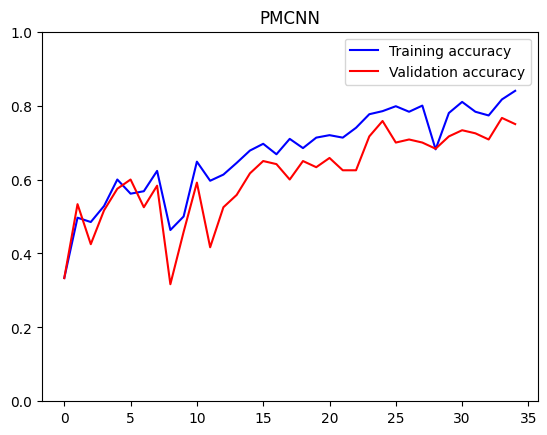

In [ ]:
model = PMCNN(train_dataset[0][0].shape, 3).to(device)
print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

train_acc, valid_acc, labels, predictions = train_and_eval(model, train_loader, test_loader, 35, 0.001)
print(compute_metrics(labels, predictions))
plot_accuracy(train_acc, valid_acc, "PMCNN")

Defining functions to save/load model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

def save_model(model, path):
  torch.save(model.state_dict(), path)

def load_model(model, path):
  model.load_state_dict(torch.load(path, map_location=torch.device(device)))
  return model

Mounted at /content/drive


In [ ]:
save_model(model, "/content/drive/MyDrive/Colab Notebooks/models/PMCNN.pt")

In [ ]:
model = PMCNN(torch.empty(3, 256, 256).shape, 3).to(device)
model = load_model(model, "/content/drive/MyDrive/Colab Notebooks/models/PMCNN.pt")

In [ ]:
!pip install Flask==3.0.0 pyngrok==7.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: blinker
    Found existing installation: blinker 1.4
ERROR: Cannot uninstall 'blinker'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [ ]:
from google.colab import userdata
from pyngrok import ngrok
from flask import Flask, render_template, request, jsonify
from PIL import Image
from io import BytesIO

ngrok_key = userdata.get('ngrok_auth_key')
port = 5000

ngrok.set_auth_token(ngrok_key)
ngrok.connect(port).public_url

'https://c0fa-34-125-10-117.ngrok-free.app'

In [ ]:
def predict_picture(img, model):
  model.eval()

  with torch.no_grad():
    pred = model(transforms_test(img).unsqueeze(0).to(device))

  print(pred)
  label_pred = torch.argmax(pred, axis=1)

  classes = ["Chicken", "Pizza", "Watermelon"]
  return classes[label_pred]

Hosting flask app with user interface for image prediction

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 13:03:03] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 13:03:03] "GET /favicon.ico HTTP/1.1" 404 -
<ipython-input-10-379a2dfb48f9>:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  file_bytes = np.fromstring(image_data, np.uint8)


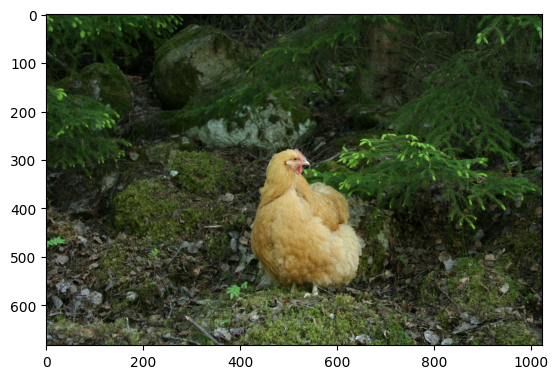

INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 13:03:11] "POST / HTTP/1.1" 200 -


tensor([[ 3.3090, -4.2442,  1.6378]])


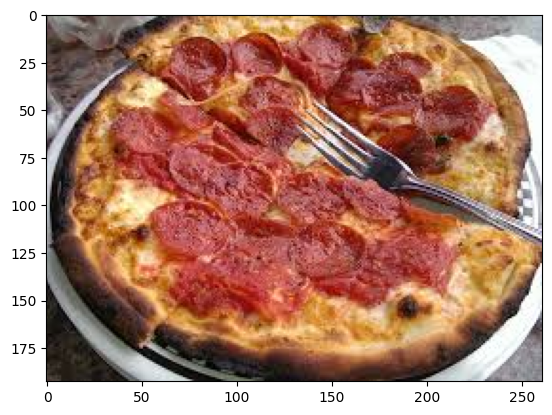

INFO:werkzeug:127.0.0.1 - - [10/Apr/2024 13:03:17] "POST / HTTP/1.1" 200 -


tensor([[-1.9241,  1.6795, -0.7809]])


In [ ]:
app = Flask(__name__, template_folder='/content')

@app.route('/')
def home():
  return render_template('index.html')

@app.route('/', methods=['POST'])
def predict_image():
    image_data = request.files['image'].read()

    file_bytes = np.fromstring(image_data, np.uint8)
    file_jpgdata = BytesIO(file_bytes)

    pilImage = Image.open(file_jpgdata)
    plt.imshow(pilImage)
    plt.show()

    return jsonify({"message": f"Predicted class: {predict_picture(pilImage, model)}"})


app.run(port = port)